# Load in Libraries

In [30]:
import numpy as np
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import math

from landlab.components import OverlandFlow
from landlab.io.esri_ascii import read_esri_ascii
from landlab.grid.mappers import map_max_of_node_links_to_node
from landlab.plot import imshow

# Set up RasterModelGrid

No vegetation scenario

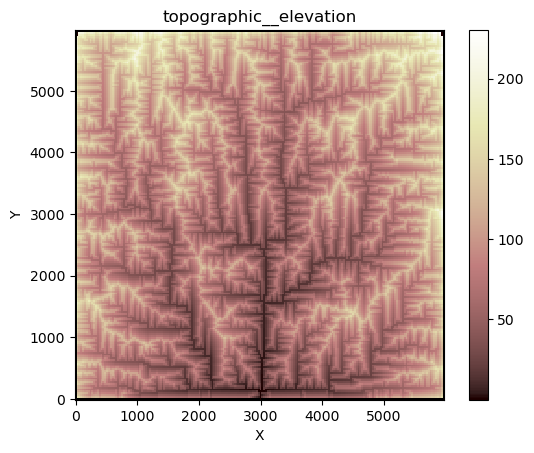

In [31]:
#read in artificially generated raster
grid, z = read_esri_ascii("square-test-basin.asc", name="topographic__elevation")

#close all boundaries
grid.set_closed_boundaries_at_grid_edges(True, True, True, True)

#open the outlet 
#This DEM was generated using Landlab and the outlet node ID was known
my_outlet_node = 100
grid.status_at_node[my_outlet_node] = grid.BC_NODE_IS_FIXED_VALUE

#plot elevation
figure('elevation')
imshow.imshow_grid_at_node(grid, "topographic__elevation")

# Adding Fields to Grid

In [32]:
#add surface water depth (1 m everywhere)
grid.add_ones("surface_water__depth", at = "node", clobber = True)

#now add rouughness
grid.add_zeros("rough",  at = "node", clobber=True)

#map roughness to link
r = grid.map_mean_of_link_nodes_to_link("rough")

#add to grid
grid.add_field("mannings_n", r, at = "link", clobber=True)

#check that they are there
grid.at_link.keys()

['mannings_n']

# Define function for constant M

In [52]:
#hydrograph function for constant mannings n
def constantM(n):
    
    #initializing list
    hydrograph_time = []
    discharge_at_outlet = []

    #setting up run time params
    run_time = 100
    elapsed_time = 0.0
    
    #define grid
    grid1 = grid
    
    #initializing Overland flow with a constant n
    of = OverlandFlow(grid1,
                      alpha = 0.7,
                      mannings_n = n, 
                      rainfall_intensity=2*(10**-6), #convert mm/hr to m/s
                      steep_slopes=True)
        
    #running the model
    while elapsed_time <= run_time:
        of.dt = of.calc_time_step() # Adaptive time step
        time_steps.append(of.dt)
        
        of.overland_flow() #run model
        
        #get discharge at outlet link
        outlet = grid1.at_link['surface_water__discharge'][299]
        
        hydrograph_time.append(elapsed_time / 3600.) # convert seconds to hours
        discharge_at_outlet.append(np.abs(outlet) * grid1.dx) # append discharge in m^3/s
        
        elapsed_time += of.dt #update elapsed time
        
    return grid1, hydrograph_time, discharge_at_outlet, elapsed_time # maybe we don't need to see the elapsed time

# Baptist Formula Class

In [56]:
#class for calc roughness and convert to mannings n
class FlowResistance():
    def Baptist_2007(self, mannings_n, drag_coef, veg_den, veg_diam, veg_height, gravity, van_karman, water_depth):
        bed_roughness = (water_depth**(1/6))/mannings_n
        #The baptist equation 
        Cr1=1/np.sqrt((1/(bed_roughness**2))+drag_coef*veg_den*veg_diam*veg_height/(2*gravity)) + (np.sqrt(gravity)/van_karman)*np.log(water_depth/veg_height)
        Cr2=1/np.sqrt((1/(bed_roughness**2))+drag_coef*veg_den*veg_diam*veg_height/(2*gravity)) 
        if (veg_height>=water_depth).all():
            return Cr2
        else:
            return Cr1
        
    def chezy_to_manning(self,water_depth,Chezy):
        #The actual relationship
        n=water_depth**(1/6)/Chezy
        return n

# Function for roughness that varies with water depth

In [60]:
#using variable mannings n value
def newOverlandFlow(den, diam, height, mannings_n):
    
        
    #initializing list
    hydrograph_time = []
    discharge_at_outlet = []
    
    #set up time steps
    run_time = 100
    elapsed_time = 0.0
    
    #initialize grid
    grid2 = grid
    
    #initialize model
    of = OverlandFlow(grid2, 
                      alpha = 0.7,
                      rainfall_intensity=2*(10**-6), 
                      steep_slopes=True)
    
    #start loop
    while elapsed_time <= run_time:
        new_manning = []
        for depth in grid2.at_link["surface_water__depth"]:
            #call flow resistance class
            flow_resistance = FlowResistance()
            #calculate Chezy's coefficient
            cr = flow_resistance.Baptist_2007(mannings_n=mannings_n, 
                                              drag_coef=1.0, 
                                              veg_den=den, 
                                              veg_diam=diam, 
                                              veg_height=height, 
                                              gravity=9.81, 
                                              van_karman=0.41, 
                                              water_depth=depth)
        
            #convert new chezy to manning
            n=flow_resistance.chezy_to_manning(depth,cr)
            new_manning.append(n)
        
    
        #add new mannings to links
        grid2.add_field("mannings_n", new_manning, at = "link", clobber=True)
        of.dt = of.calc_time_step()     # Adaptive time step
        of.overland_flow() #run the model
        
         #get discharge at outlet link
        outlet = grid2.at_link['surface_water__discharge'][299]
        
        hydrograph_time.append(elapsed_time / 3600.) # convert seconds to hours
        discharge_at_outlet.append(np.abs(outlet) * grid2.dx) # append discharge in m^3/s
        
        elapsed_time += of.dt #update time step
    
    return grid2, hydrograph_time, discharge_at_outlet


In [ ]:
#running model for grass
time_constant_grass, discharge_constant_grass = constantM(0.02)[1:3] 
time_variable_grass, discharge_variable_grass = newOverlandFlow(den = 4500, 
                                                                diam = 0.003, 
                                                                height = 0.15, 
                                                                mannings_n = 0.02)[1:3] 


#running model for shrubs
time_constant_shrub, discharge_constant_shrub = constantM(0.1)[1:3] 
time_variable_shrub, discharge_variable_shrub = newOverlandFlow(den = 500, 
                                                                diam = 0.01, 
                                                                height = 0.5, 
                                                                mannings_n = 0.1)[1:3] 


#running model for tree
time_constant_tree, discharge_constant_tree = constantM(0.1)[1:3] 
time_variable_tree, discharge_variable_tree = newOverlandFlow(den = 1, 
                                                              diam = 0.7, 
                                                              height = 10, 
                                                              mannings_n = 0.1)[1:3] 



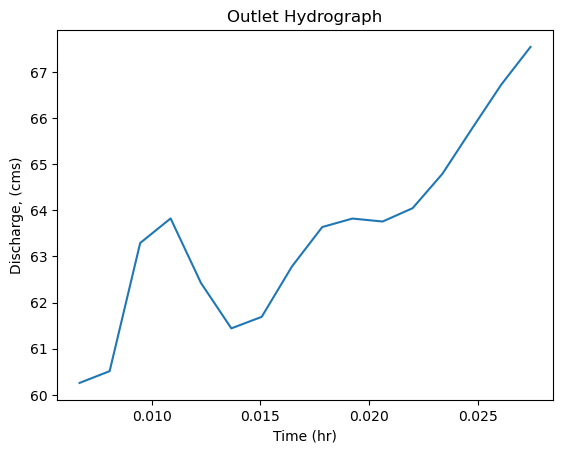

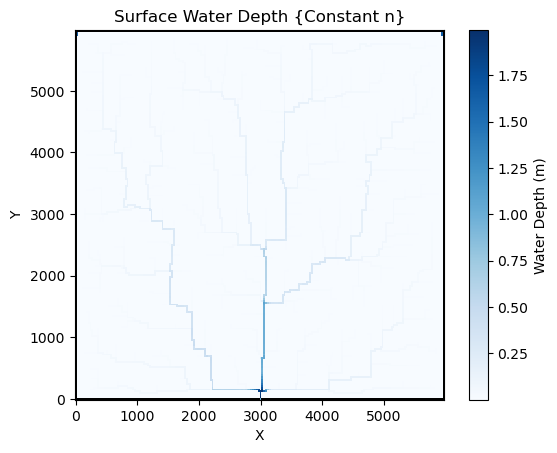

In [65]:
#plot hydrograph at outlet link
time_constant_grass, discharge_constant_grass = constantM(0.02)[1:3] 
plt.plot(time[5:], discharge[5:])
plt.xlabel('Time (hr)')
plt.ylabel('Discharge, (cms)')
plt.title('Outlet Hydrograph')
plt.show()

#run function and return grid
grass_constant_m = constantM(n = 0.02)[0]

#figure showing water depth on grid
figure('water depth')
imshow.imshow_grid(grass_constant_m, "surface_water__depth", 
                   cmap = 'Blues', 
                   plot_name = 'Surface Water Depth {Constant n}', 
                   var_name = 'Water Depth (m)')

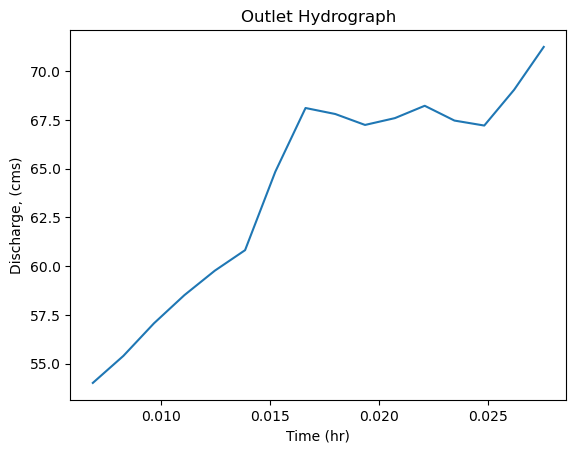

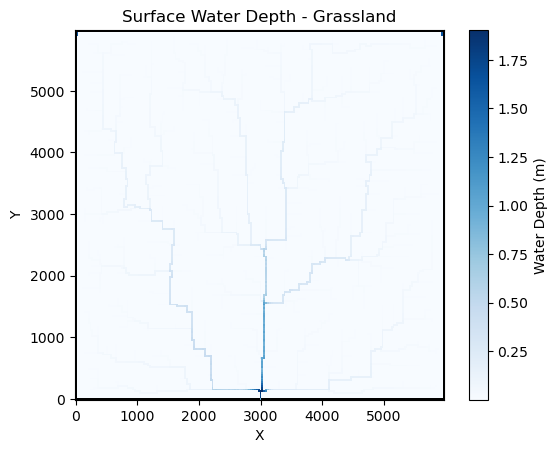

In [63]:
time, discharge = newOverlandFlow(den = 4500, diam = 0.003, height = 0.15, mannings_n = 0.02)[1:3] # https://landlab.readthedocs.io/en/master/user_guide/overland_flow_user_guide.html
plt.plot(time[5:], discharge[5:])
plt.xlabel('Time (hr)')
plt.ylabel('Discharge, (cms)')
plt.title('Outlet Hydrograph')
plt.show()


# calculate the roughness for different vegetation

# Veg 1 - grassland
# varrying n
#print(newOverlandFlow(den = 10000, diam = 0.003, height = 0.15, mannings_n = 0.02)[1])
grass_varying_n = newOverlandFlow(den = 4500, diam = 0.003, height = 0.15, mannings_n = 0.02)[0]
#figure('water depth')
imshow.imshow_grid(grass_varying_n,  "surface_water__depth", 
                           cmap = 'Blues', 
                           plot_name = 'Surface Water Depth - Grassland', # figure out how to change title
                           var_name = 'Water Depth (m)',
                           at = 'node')
#print(len(new_manning))
#print(grid.number_of_links)
#print(elapsed_time)